In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

##Loading in data file
csv_data = "Manhattan12.csv"
df = pd.read_csv(csv_data, header = 4)

In [164]:
##Show the shape of the dataset
print(df.shape)

(27395, 21)


In [165]:
##Rename incorrectly formatted column names 
def remove_newlines(df):
    old_columns = df.columns
    cleaned_columns = [col.replace("\n", " ") for col in old_columns]
    #Renaming DF columns
    df.rename(dict(zip(old_columns, cleaned_columns)), axis = 1, inplace = True)
    return df

df = remove_newlines(df)

In [166]:
##Create list of categorical variables and numerical values 
cat_variables = list(df.select_dtypes(include=['category', 'object']))
num_variables = list(df.select_dtypes(include=['int', 'float']))
print(num_variables)

['BOROUGH', 'BLOCK', 'LOT', 'ZIP CODE', 'COMMERCIAL UNITS', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE']


In [167]:
##For each numerical column, remove the ',' the '$' for the sale price, and then convert them to numeric.
def clean_numericals(df, df_numericals_list):
    for column in df_numericals_list:
        df[column] = df[column].astype("string")
        df[column] = df[column].str.replace('$','', regex = True)
        df[column] = df[column].str.replace(",", "", regex = True)
        df[column] = pd.to_numeric(df[column])
    return df
#appending sale price and sale date to num_variables to convert it also
num_variables.append("SALE PRICE")
df = clean_numericals(df, num_variables)


In [168]:
##Convert SALE_DATE to datetime
df["SALE DATE"] = pd.to_datetime(df["SALE DATE"], format = '%d/%m/%Y')

In [169]:
## For each categorical variable, replace with NaNs. Also same with 0s
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip().replace('', np.nan)

#Need to convert columns to numeric for replacement
numeric_conversion_list = ["RESIDENTIAL UNITS", "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET"]
df = clean_numericals(df, numeric_conversion_list)
df.replace(0,np.nan, inplace=True)

    

In [170]:
##Show a summary of all missing values as well as the summary statistics
print(df.describe())
#Missing values
df.isnull().sum()


       BOROUGH         BLOCK           LOT  EASE-MENT      ZIP CODE  \
count  27395.0  27395.000000  27395.000000        0.0  27394.000000   
mean       1.0   1109.666728    741.789086        NaN  10029.226217   
std        0.0    465.994469    819.422424        NaN     34.966983   
min        1.0      7.000000      1.000000        NaN  10001.000000   
25%        1.0    877.000000     37.000000        NaN  10016.000000   
50%        1.0   1047.000000   1007.000000        NaN  10019.000000   
75%        1.0   1411.000000   1233.000000        NaN  10027.000000   
max        1.0   2250.000000   9117.000000        NaN  10463.000000   

       RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  \
count       11023.000000       3433.000000  17691.000000       4489.000000   
mean            4.390003          2.992426      3.545249       5893.466028   
std            23.260831         12.689861     19.482767       7884.729624   
min             1.000000          1.000000      

BOROUGH                               0
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            3454
TAX CLASS AT PRESENT                143
BLOCK                                 0
LOT                                   0
EASE-MENT                         27395
BUILDING CLASS AT PRESENT           143
ADDRESS                               0
APART MENT NUMBER                 14570
ZIP CODE                              1
RESIDENTIAL UNITS                 16372
COMMERCIAL UNITS                  23962
TOTAL UNITS                        9704
LAND SQUARE FEET                  22906
GROSS SQUARE FEET                 23069
YEAR BUILT                         6441
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         7593
SALE DATE                             0
dtype: int64

In [171]:
def drop_columns(df, drop_columns_list):
    for column in drop_columns_list:
        df.drop([column], axis = 1, inplace = True)
    return df
    
drop_columns_list = ['BOROUGH','EASE-MENT','APART MENT NUMBER']

df = drop_columns(df, drop_columns_list)
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1306,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,2214693.0,2013-05-20
1,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1307,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1654656.0,2013-05-16
2,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1308,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1069162.0,2013-05-23
3,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1309,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1374637.0,2013-05-15
4,NaN,13 CONDOS - ELEVATOR APARTMENTS,NaN,738,1310,NaN,345 WEST 14TH STREET,10014.0,NaN,NaN,NaN,NaN,NaN,NaN,2,R4,1649565.0,2013-05-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27390,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2170,400,V1,44 FAIRVIEW AVENUE,10040.0,NaN,NaN,NaN,16217.0,NaN,NaN,4,V1,NaN,2013-04-29
27391,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,75,V1,BENNETT AVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,495000.0,2013-06-26
27392,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,75,V1,BENNETT AVENUE,10033.0,NaN,NaN,NaN,4150.0,NaN,NaN,4,V1,NaN,2013-04-02
27393,WASHINGTON HEIGHTS UPPER,31 COMMERCIAL VACANT LAND,4,2180,76,V1,N/A MAGAW PLACE,10033.0,NaN,NaN,NaN,760.0,NaN,NaN,4,V1,NaN,2013-06-26


In [172]:
##Drop duplicates
df.drop_duplicates(inplace=True)

In [173]:
##Drop NAN 

In [174]:
df = df.dropna()
df

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
24,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,385,1,C7,17 AVENUE B,10009.0,7.0,1.0,8.0,2093.0,5852.0,1997.0,2,C7,283.0,2013-04-18
26,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,397,33,C7,14 AVENUE B,10009.0,25.0,2.0,27.0,3574.0,18212.0,1925.0,2,C7,13185684.0,2013-01-31
30,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,398,53,C7,170 EAST 2ND STREET,10009.0,36.0,3.0,39.0,4452.0,17664.0,1900.0,2,C7,3810602.0,2012-10-26
31,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,400,56,C4,203 EAST 4TH STREET,10009.0,10.0,1.0,10.0,2404.0,6975.0,1900.0,2,C4,7333333.0,2013-04-09
32,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,400,57,C4,201 EAST 4TH STREET,10009.0,9.0,1.0,9.0,2404.0,6875.0,1900.0,2,C4,7333333.0,2013-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27057,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,2,2180,13,C7,500 FT WASHINGTON AVENUE,10033.0,56.0,1.0,57.0,14150.0,44295.0,1925.0,2,C7,8620000.0,2013-03-22
27059,WASHINGTON HEIGHTS UPPER,07 RENTALS - WALKUP APARTMENTS,2,2180,120,C7,4321 BROADWAY,10033.0,69.0,5.0,74.0,12400.0,54000.0,1949.0,2,C7,11400000.0,2013-04-11
27060,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,2,2158,16,D7,440 AUDUBON AVENUE,10040.0,68.0,3.0,71.0,14231.0,66240.0,1911.0,2,D7,7810000.0,2012-08-29
27064,WASHINGTON HEIGHTS UPPER,08 RENTALS - ELEVATOR APARTMENTS,2,2175,33,D7,4720 BROADWAY,10040.0,50.0,2.0,52.0,12050.0,52378.0,1920.0,2,D7,11360000.0,2013-05-30


In [175]:
##Removing outliers
#This is Ella's code, this may be worth looking at
df = df.select_dtypes(include = ['int','float'])
def removing_outliers (df, threshold):
    num_df = df.select_dtypes(include = ['int','float'])
    z = np.abs((num_df - num_df.mean()) / num_df.std())  ## calclulating the z score for numerical columns in the dataframe
    outliers = df[(z > threshold).any(axis=1)]  ## outliers identified in the datframe
    
    
    return df[(z <= threshold).all (axis =1)]    ## returns a df with the removal of outliers from the dataframe
df = removing_outliers (df, 3)
df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
26,397,33,10009.0,25.0,2.0,27.0,3574.0,18212.0,1925.0,2,13185684.0
30,398,53,10009.0,36.0,3.0,39.0,4452.0,17664.0,1900.0,2,3810602.0
31,400,56,10009.0,10.0,1.0,10.0,2404.0,6975.0,1900.0,2,7333333.0
32,400,57,10009.0,9.0,1.0,9.0,2404.0,6875.0,1900.0,2,7333333.0
33,400,58,10009.0,9.0,1.0,10.0,2404.0,7110.0,1900.0,2,7333333.0
...,...,...,...,...,...,...,...,...,...,...,...
27052,2175,45,10040.0,68.0,6.0,74.0,15800.0,58400.0,1920.0,2,11300000.0
27057,2180,13,10033.0,56.0,1.0,57.0,14150.0,44295.0,1925.0,2,8620000.0
27059,2180,120,10033.0,69.0,5.0,74.0,12400.0,54000.0,1949.0,2,11400000.0
27060,2158,16,10040.0,68.0,3.0,71.0,14231.0,66240.0,1911.0,2,7810000.0


In [176]:
##Show the shape of the resulting dataframe
df.shape


(428, 11)

In [177]:
##Consider the log of the prices and normalise the data.
df["LOG PRICE"] = np.log(df["SALE PRICE"])

#maybe log all of the values as well? might make correlation better
# for columns in df:
#     df[columns] = np.log(df[columns])


#Normalising the data using code from tutorial workshop
def normalise(df):
    num_cols = df.select_dtypes(include=[np.number]).copy()
    df_norm = ((num_cols - num_cols.min()) / (num_cols.max() - num_cols.min()))
    return df_norm

df = normalise(df)
df = df[df["LOG PRICE"] >= 0.7]
df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
26,0.173952,0.183908,0.108108,0.201681,0.111111,0.209677,0.200090,0.149085,0.533333,0.333333,0.173496,0.889445
30,0.174403,0.298851,0.108108,0.294118,0.222222,0.306452,0.256670,0.144084,0.255556,0.333333,0.050139,0.811095
31,0.175304,0.316092,0.108108,0.075630,0.000000,0.072581,0.124694,0.046540,0.255556,0.333333,0.096491,0.852414
32,0.175304,0.321839,0.108108,0.067227,0.000000,0.064516,0.124694,0.045628,0.255556,0.333333,0.096491,0.852414
33,0.175304,0.327586,0.108108,0.067227,0.000000,0.072581,0.124694,0.047772,0.255556,0.333333,0.096491,0.852414
...,...,...,...,...,...,...,...,...,...,...,...,...
27052,0.975214,0.252874,0.527027,0.563025,0.555556,0.588710,0.987949,0.515824,0.477778,0.333333,0.148684,0.879704
27057,0.977467,0.068966,0.432432,0.462185,0.000000,0.451613,0.881621,0.387107,0.533333,0.333333,0.113421,0.862617
27059,0.977467,0.683908,0.432432,0.571429,0.444444,0.588710,0.768849,0.475671,0.800000,0.333333,0.150000,0.880260
27060,0.967553,0.086207,0.527027,0.563025,0.222222,0.564516,0.886841,0.587368,0.377778,0.333333,0.102763,0.856389


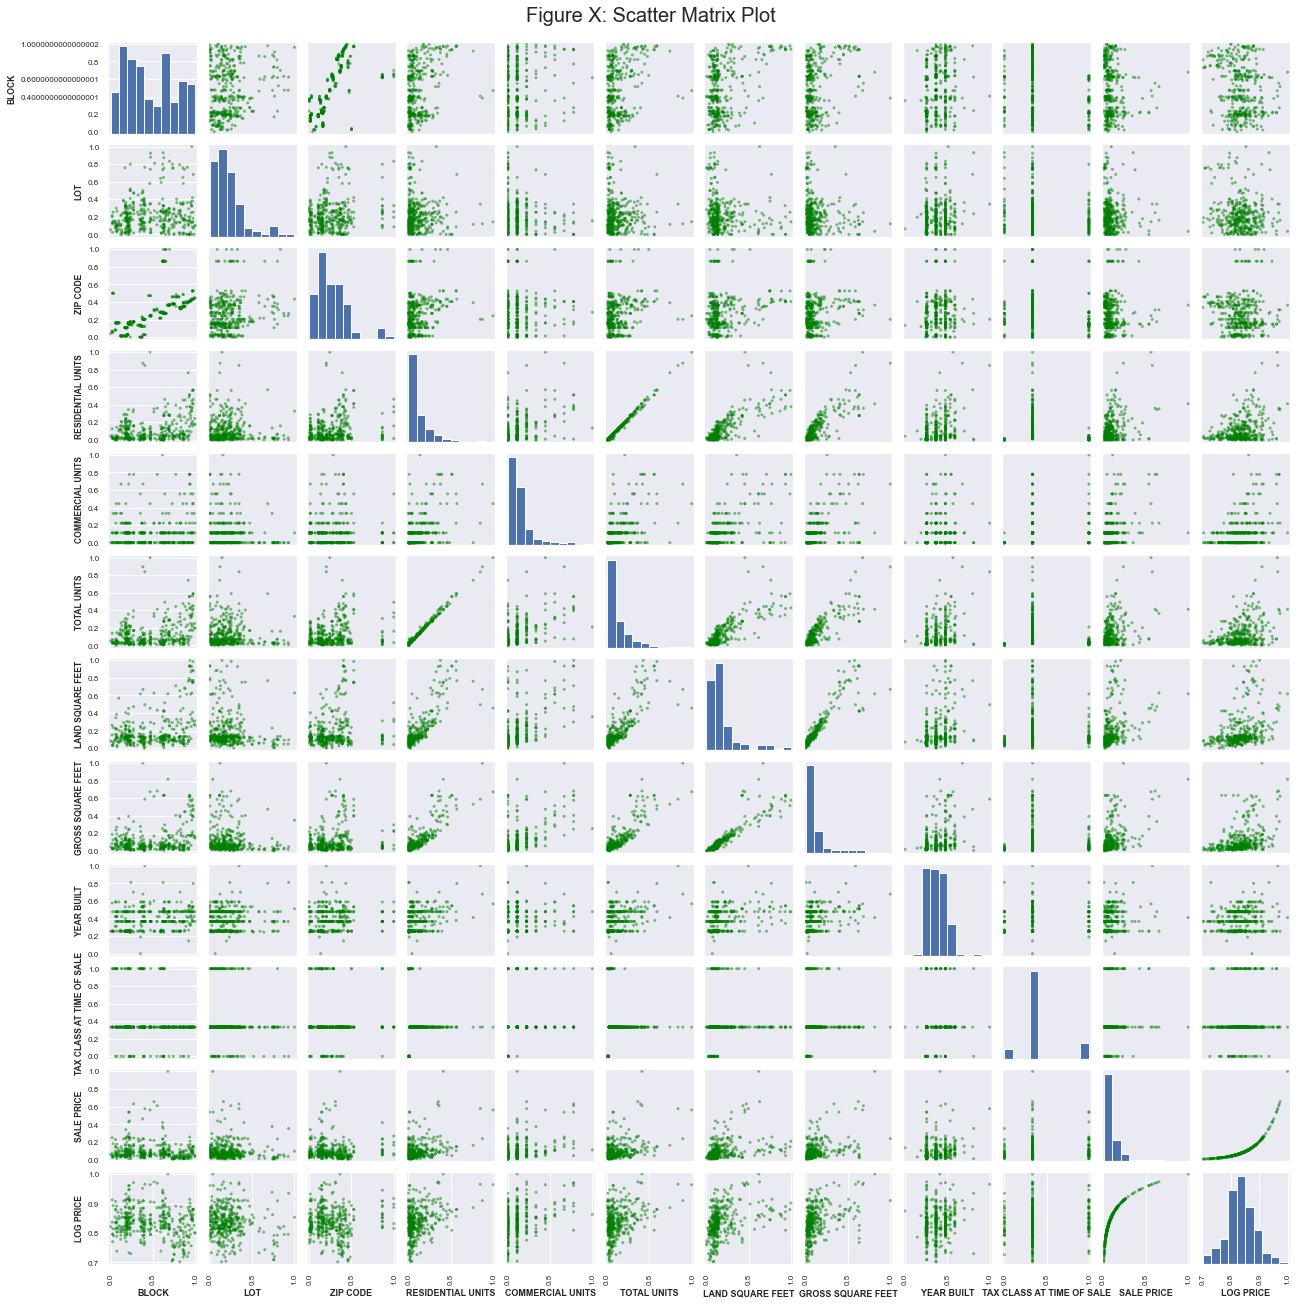

In [178]:
##Data exploration
scatt_matrix=pd.plotting.scatter_matrix(df, figsize=(18,18), diagonal='hist',color='green')
plt.suptitle('Figure X: Scatter Matrix Plot', fontsize=20,y=1)
plt.tight_layout()  ## gives the gaps inbetween
## now adjusting the axis lables for each subplot to make legible
for ax in scatt_matrix.flatten():
    # Set x label to corresponding variable name
    ax.set_xlabel(ax.get_xlabel(), fontsize=9)
    # Set y label to corresponding variable name
    ax.set_ylabel(ax.get_ylabel(), fontsize=8.6)
    #making the font of the text bolder
    ax.title.set_fontweight('bold')
    ax.xaxis.label.set_fontweight('bold')
    ax.yaxis.label.set_fontweight('bold')
plt.show()



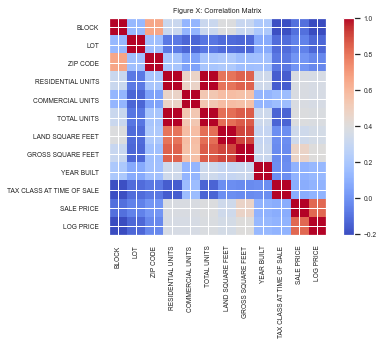

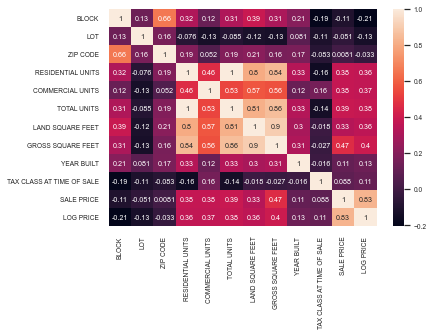

<Figure size 1296x1152 with 0 Axes>

LOG PRICE                    1.000000
SALE PRICE                   0.828127
GROSS SQUARE FEET            0.399580
TOTAL UNITS                  0.379524
COMMERCIAL UNITS             0.367647
RESIDENTIAL UNITS            0.364505
LAND SQUARE FEET             0.359147
YEAR BUILT                   0.131053
TAX CLASS AT TIME OF SALE    0.110660
ZIP CODE                    -0.032941
Name: LOG PRICE, dtype: float64

In [179]:
# create correlation matrix
corr_matrix = df.corr()
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Figure X: Correlation Matrix')
plt.show()

sns.heatmap(df.corr(),annot=True)
plt.figure(figsize = (18,16))
sns.set(font_scale=0.6)  ## adjsuting the font size of the numbers in the heatmap
plt.show()

corr_matrix["LOG PRICE"].sort_values(ascending=False).head(10)

0.8534843567537156
0.49851823105502757


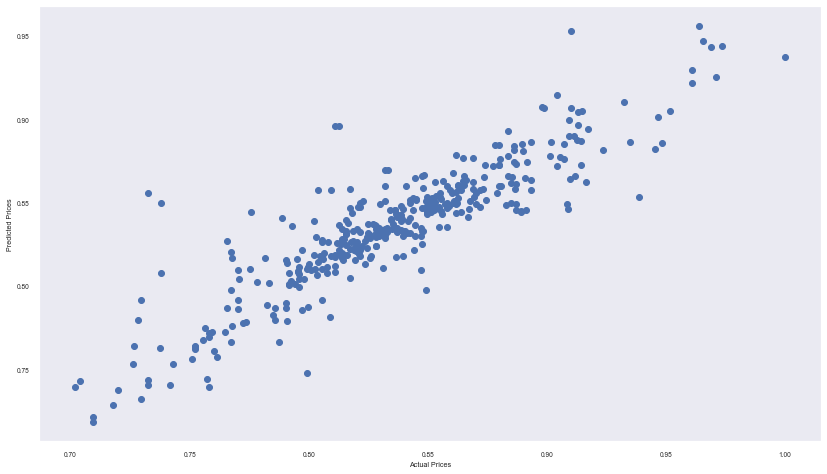

In [180]:
#Building intitial model
features = ['BLOCK', 'ZIP CODE', 'LAND SQUARE FEET', "TOTAL UNITS", "GROSS SQUARE FEET"]

X = df[features]
Y = df['LOG PRICE']
results = {}
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=0)
model = RandomForestRegressor(n_estimators = 200, max_depth = 80, bootstrap = True, max_features = "sqrt", min_samples_leaf = 2, min_samples_split = 2)
model.fit(trainX, trainY)

print(model.score(trainX, trainY))

print(model.score(testX, testY))

pred_Y = model.predict(X)
plt.figure(figsize=(14, 8))
plt.plot(Y, pred_Y, 'o')
plb.xlabel('Actual Prices')
plb.ylabel('Predicted Prices')
plt.grid()
plt.show()

##RUN TO FIND OUT OPTIMAL PARAMETERS OF RANDOM FOREST - WILL MAKE CPU GO TO 100% FOR A BIT

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# rf = RandomForestRegressor()
# rf_random = GridSearchCV(estimator = rf, param_grid = random_grid,cv = 5, verbose=2, n_jobs = -1)
# rf_random.fit(trainX, trainY)
# rf_random.best_params_

In [181]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [182]:
df

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
26,0.173952,0.183908,0.108108,0.201681,0.111111,0.209677,0.200090,0.149085,0.533333,0.333333,0.173496,0.889445
30,0.174403,0.298851,0.108108,0.294118,0.222222,0.306452,0.256670,0.144084,0.255556,0.333333,0.050139,0.811095
31,0.175304,0.316092,0.108108,0.075630,0.000000,0.072581,0.124694,0.046540,0.255556,0.333333,0.096491,0.852414
32,0.175304,0.321839,0.108108,0.067227,0.000000,0.064516,0.124694,0.045628,0.255556,0.333333,0.096491,0.852414
33,0.175304,0.327586,0.108108,0.067227,0.000000,0.072581,0.124694,0.047772,0.255556,0.333333,0.096491,0.852414
...,...,...,...,...,...,...,...,...,...,...,...,...
27052,0.975214,0.252874,0.527027,0.563025,0.555556,0.588710,0.987949,0.515824,0.477778,0.333333,0.148684,0.879704
27057,0.977467,0.068966,0.432432,0.462185,0.000000,0.451613,0.881621,0.387107,0.533333,0.333333,0.113421,0.862617
27059,0.977467,0.683908,0.432432,0.571429,0.444444,0.588710,0.768849,0.475671,0.800000,0.333333,0.150000,0.880260
27060,0.967553,0.086207,0.527027,0.563025,0.222222,0.564516,0.886841,0.587368,0.377778,0.333333,0.102763,0.856389


In [183]:
model = KMeans(n_clusters=4,init='random',max_iter=50,random_state=1)
model.fit(df)
print(' score = ', model.score(df))

 score =  -63.74106661495866


/home/drt15/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [184]:
labels = model.labels_
md = pd.Series(labels)
df['clust'] = md
df.head(5)

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE,clust
26,0.173952,0.183908,0.108108,0.201681,0.111111,0.209677,0.200090,0.149085,0.533333,0.333333,0.173496,0.889445,3.0
30,0.174403,0.298851,0.108108,0.294118,0.222222,0.306452,0.256670,0.144084,0.255556,0.333333,0.050139,0.811095,2.0
31,0.175304,0.316092,0.108108,0.075630,0.000000,0.072581,0.124694,0.046540,0.255556,0.333333,0.096491,0.852414,2.0
32,0.175304,0.321839,0.108108,0.067227,0.000000,0.064516,0.124694,0.045628,0.255556,0.333333,0.096491,0.852414,2.0
33,0.175304,0.327586,0.108108,0.067227,0.000000,0.072581,0.124694,0.047772,0.255556,0.333333,0.096491,0.852414,2.0


In [185]:
centroids = model.cluster_centers_
print ('centroids', centroids)

centroids [[0.810856   0.19525106 0.39366999 0.43962848 0.34210526 0.45479626
  0.68615055 0.5125717  0.49239766 0.33333333 0.20902622 0.87772277]
 [0.73361079 0.27277721 0.42557631 0.09194266 0.07189542 0.10139943
  0.14101461 0.07579551 0.39125817 0.29656863 0.07297073 0.81356127]
 [0.23962156 0.20101259 0.12105856 0.08458383 0.07142857 0.09394201
  0.13070152 0.07267682 0.36362434 0.29960317 0.09591552 0.83907903]
 [0.31168528 0.17390379 0.20795796 0.01758481 0.15020576 0.03569295
  0.14635931 0.07922006 0.37345679 1.         0.12335321 0.8482224 ]]


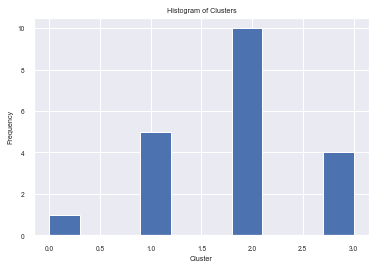

In [186]:
plt.hist(df['clust'])
plt.title('Histogram of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

In [187]:
df.groupby('clust').mean()


,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,LOG PRICE
clust,,,,,,,,,,,,
0.0,0.171699,0.017241,0.108108,0.008403,0.000000,0.016129,0.107617,0.041658,0.255556,1.000000,0.061184,0.823660
1.0,0.208112,0.250575,0.086486,0.031933,0.022222,0.040323,0.122761,0.066398,0.315556,0.466667,0.037963,0.792318
2.0,0.221947,0.231034,0.116216,0.126891,0.066667,0.131452,0.152391,0.076425,0.358889,0.333333,0.101923,0.850651
3.0,0.220933,0.145115,0.114865,0.170168,0.055556,0.173387,0.161297,0.109121,0.438889,0.333333,0.122701,0.853250


In [188]:
######## 2D plot of the clusters
pca_data = PCA(n_components=2).fit(df)
pca_2d = pca_data.transform(df)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=labels)
plt.title('Housing Clusters')
plt.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [189]:
def elbow(data):
    print("\nPlotting elbow method...")
    sse = {}
    for k in range(2, 20, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
    print("DONE")
elbow(df)


Plotting elbow method...


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [191]:
df.to_csv('out.csv')